In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')

In [2]:
star = pd.read_csv('Star.csv', index_col=0)

In [3]:
star.head()

,tmathssk,treadssk,classk,totexpk,sex,freelunk,race,schidkn
2,473,447,small.class,7,girl,no,white,63
3,536,450,small.class,21,girl,no,black,20
5,463,439,regular.with.aide,0,boy,yes,black,19
11,559,448,regular,16,boy,no,white,69
12,489,447,small.class,5,boy,yes,white,79


In [5]:
len(np.unique(star.schidkn))

79

In [6]:
schools = star.schidkn.unique()

In [7]:
schools

array([63, 20, 19, 69, 79,  5, 16, 56, 11, 66, 38, 43, 71, 52, 54, 12, 21,
       76,  8, 59, 31, 27, 17,  9, 39, 55, 58, 49,  7, 37, 70, 40, 48, 10,
       80, 28, 41, 61, 47, 35, 24, 33, 30, 50, 46,  1, 45, 78, 22, 32,  4,
       14, 44, 23, 64,  2, 25, 73, 67, 13, 42, 57, 65,  3, 36, 60, 51, 68,
       72, 34, 29, 62, 75, 53, 26, 15, 18, 74,  6])

In [34]:
df = pd.DataFrame()

In [35]:
for col in ['tmathssk', 'treadssk', 'totexpk']:
    data = star.loc[:,col]
    df[col] = (data - min(data))/(max(data) - min(data))

In [36]:
data = star.loc[:,['classk', 'sex', 'freelunk','race']]
df = df.merge(pd.get_dummies(data), left_index=True, right_index=True)

In [39]:
df.columns[[4, 6, 8, 11]]

Index(['classk_regular.with.aide', 'sex_boy', 'freelunk_no', 'race_other'], dtype='object')

In [40]:
df.drop(df.columns[[4, 6, 8, 11]], axis=1, inplace=True)

In [42]:
df.columns = ['math', 'reading', 'year_teaching', 'regular class', 'small class', 'is_girl', 'free lunch', 'black','white']

In [43]:
df.head()

,math,reading,year_teaching,regular class,small class,is_girl,free lunch,black,white
2,0.500000,0.423077,0.259259,0,1,1,0,0,1
3,0.705882,0.432692,0.777778,0,1,1,0,1,0
5,0.467320,0.397436,0.000000,0,0,0,1,1,0
11,0.781046,0.426282,0.592593,1,0,0,0,0,1
12,0.552288,0.423077,0.185185,0,1,0,1,0,1


In [44]:
df.to_csv('Star_normalized.csv')

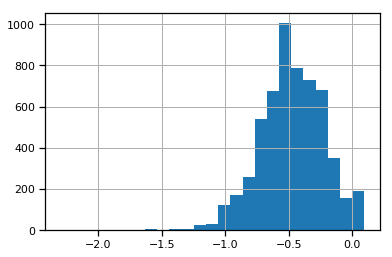

In [46]:
df.math.apply(lambda x:np.log(x+0.1)).hist(bins=25)

In [54]:
pooled_code = """
data {
    int<lower=0>  N;
    vector[N] x;
    vector[N] y;
}
parameters {
    vector[2] beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(beta[1] + beta[2]*x, sigma);
}
"""

In [51]:
import pystan

pool_data_dict = {
    'N': df.shape[0],
    'x': df.loc[:,'year_teaching'],
    'y': df.loc[:, 'math']
}

In [55]:
pooled_fit = pystan.stan(model_code=pooled_code, data = pool_data_dict, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5d7650c75bf8dd34a5a9e5f7bc72d8e4 NOW.
/opt/conda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpv8loutmk/stanfit4anon_model_5d7650c75bf8dd34a5a9e5f7bc72d8e4_6784350175081624278.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [56]:
pooled_sample = pooled_fit.extract(permuted=True)

In [57]:
b0, m0 = pooled_sample['beta'].T.mean(1)

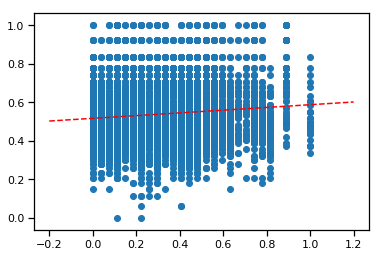

In [58]:
plt.scatter(df.year_teaching, df.math)
xvals = np.linspace(-0.2, 1.2)
plt.plot(xvals, m0*xvals+b0, 'r--')